In [10]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from htmldate import find_date
from util.api import get_lts_list,make_columns_monad
from selenium import webdriver
import requests
from bs4 import BeautifulSoup
import re
%matplotlib inline
plt.style.use('classic')

In [16]:
lts_list = get_lts_list()
df_list = []
df_by_category_list = []

print(lts_list)

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/dfs/lts-{lts}/lts-{lts}.df')
    print(f'../../data/dfs/lts-{lts}/lts-{lts}.df')
    print(df)
    df_list.append(df)

Index(['0-7'], dtype='object')
../../data/dfs/lts-0-7/lts-0-7.df
                                                 package  version  \
AC-Vector-2.3.2                                AC-Vector    2.3.2   
BlastHTTP-1.0.1                                BlastHTTP    1.0.1   
BlogLiterately-0.7.1.7                    BlogLiterately  0.7.1.7   
BlogLiterately-diagrams-0.1.4.3  BlogLiterately-diagrams  0.1.4.3   
Boolean-0.2.3                                    Boolean    0.2.3   
...                                                  ...      ...   
zip-archive-0.2.3.5                          zip-archive  0.2.3.5   
zlib-0.5.4.2                                        zlib  0.5.4.2   
zlib-bindings-0.1.1.5                      zlib-bindings  0.1.1.5   
zlib-enum-0.2.3.1                              zlib-enum  0.2.3.1   
zlib-lens-0.1                                  zlib-lens      0.1   

                                      stability  \
AC-Vector-2.3.2                  [experimental]   
Blas

In this section, we respond the following two questions:
​
- How are packages distributed in stackage?
- How are packages using mtl distributed in Stackage?
​
For this, we make the following graphs
​
1. Line graph that shows the number of packets for each published snapshot over time
2. Bar graph that shows the evolution of the main categories of the packages
3. Bar graph that shows the evolution of the stabilities of the packages
4. Bar graph that shows the evolution of the main categories of the packages that depend of `mtl`
5. Bar graph that shows the evolution of the stabilities of the packages that depend of `mtl`
​
## RQ0. 1 - Line graph that shows the number of packets for each published snapshot over time

In [14]:
import re
def read_lines_code(fullpath):
    line_of_code = 0
    still_comment = 0
    file = open(fullpath,'r',encoding='latin-1')
    for idx,line in enumerate(file):
        no_space = line.strip()
        if no_space:
            big_comment = re.match("^({-[^#]*$)", no_space)
            if big_comment:
                still_comment += 1
                
            end_big_comment = re.match("[^#]*-}$", no_space)
            if end_big_comment:
                still_comment -= 1
                continue
            
            if still_comment != 0:
                continue
               
            comment = re.match("^\--+", no_space)
            if not comment and still_comment == 0:
                line_of_code += 1
                
    return line_of_code

In [15]:
import math

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [5]:
list_size = []
list_sizeMB = []
lts_list1 = ['19-11']
for idx,lts in enumerate(lts_list):
    size = 0
    sizeMB = 0
    folderpath = f'../../lts_downloaded/tar_package/lts-{lts}'
    print(folderpath)
    for path, dirs, files in os.walk(folderpath):
        for f in files:
            fp = os.path.join(path, f)
            sizeMB += os.stat(fp).st_size
            if f.lower().endswith('.hs'):
                try:
                    result = read_lines_code(fp)
                    size += result
                except Exception as e:
                    print('File ',fp,' with error: ',e)
    #Transform to MegaBytes          
    print("Folder LTS-" +str(lts)+ " LOC: " + str(size)+" size: " + str(convert_size(sizeMB)))
    list_size.append(size)
    list_sizeMB.append(sizeMB)
print("Las lts descargadas pesan: ",str(convert_size(sum(list_sizeMB))))

../../lts_downloaded/tar_package/lts-0-7
Folder LTS-0-7 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-2-22
Folder LTS-2-22 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-3-22
Folder LTS-3-22 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-6-35
Folder LTS-6-35 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-7-24
Folder LTS-7-24 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-9-21
Folder LTS-9-21 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-11-22
Folder LTS-11-22 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-12-14
Folder LTS-12-14 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-12-26
Folder LTS-12-26 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-13-11
Folder LTS-13-11 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-13-19
Folder LTS-13-19 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-14-27
Folder LTS-14-27 LOC: 0 size: 0B
../../lts_downloaded/tar_package/lts-15-3
Folder LTS-15-3 LOC: 0 size: 0B
../../lts_downloaded/tar_pac

In [8]:
total_pkgs = [len(df) for df in df_list]
lts_datetim=[]
for lts in lts_list:
    url = f"https://www.stackage.org/lts-{lts.replace('-','.')}"
    response = requests.get(url)
    my_date = find_date(response.content, extensive_search=True)
    date_time_obj = datetime.fromisoformat(my_date)
    lts_datetim.append(date_time_obj)
    
lts_date = ["2014-12"]
dates = [datetime(2014,12,1)]
year = 2015
for i in range (8):
    month = 0
    for i in range (4):
        month += 3
        date = str(year)+"-"+str(month)
        formato = datetime(year,month,1)
        lts_date.append(date)
        dates.append(formato)
    year += 1
    
dates = matplotlib.dates.date2num(dates)

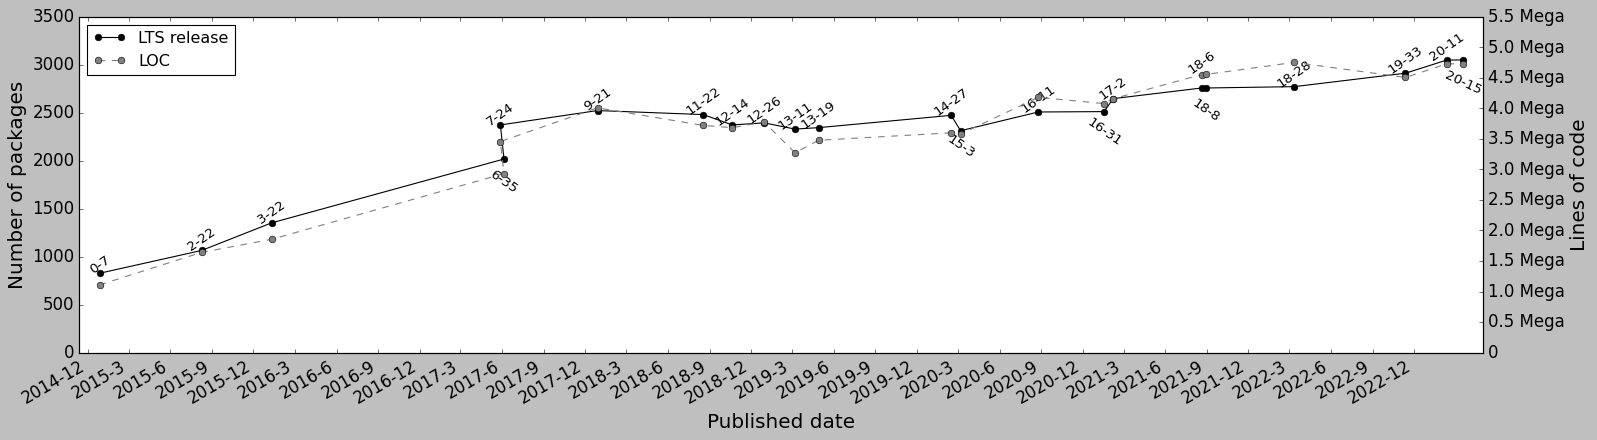

In [18]:
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(18,6))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)


#line = ax.plot(dates, total_pkgs, color='grey', marker='o',label='lts version')
lns1 = ax.plot_date(lts_datetim, total_pkgs, linestyle='solid',color='black',label='LTS release')
plt.gcf().autofmt_xdate()

for i in range(len(lts_list)):
    if i == 3 or i == 17 or i == 14:
        plt.text(lts_datetim[i],total_pkgs[i]-350,lts_list[i],ha="center",rotation = -35)
    elif i== 12:
        plt.text(lts_datetim[i],total_pkgs[i]-280,lts_list[i],ha="center",rotation = -35)
    elif i== 16:
        plt.text(lts_datetim[i],total_pkgs[i]+150,lts_list[i],ha="center",rotation = 35)
    elif i== 21:
        plt.text(lts_datetim[i],total_pkgs[i]-350,lts_list[i],ha="center",rotation = -25)
    else:
        plt.text(lts_datetim[i],total_pkgs[i],lts_list[i],ha="center",rotation = 35)
    
ax2 = ax.twinx()
lns2 = ax2.plot_date(lts_datetim, list_size, linestyle='--',color='grey',label='LOC')

ax.set_yticks([0,500, 1000, 1500, 2000, 2500, 3000,3500])
ax.set_yticklabels(['0','500', '1000', '1500', '2000', '2500', '3000','3500'],fontsize=15)

ax2.set_yticks([0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000,4000000,4500000,5000000,5500000])
ax2.set_yticklabels(['0', '0.5 Mega','1.0 Mega', '1.5 Mega', '2.0 Mega', '2.5 Mega', '3.0 Mega', '3.5 Mega', '4.0 Mega', '4.5 Mega','5.0 Mega','5.5 Mega'],fontsize=15)

ax.set_xticks(dates)
ax.set_xticklabels(lts_date,fontsize=15)

ax.set_xlabel('Published date',fontsize=18)
ax.set_ylabel('Number of packages',fontsize=18)
ax2.set_ylabel('Lines of code',fontsize=18)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left')

plt.savefig("../../graphs/rq0-1.pdf", format='pdf', bbox_inches='tight')
plt.show()